# **Welding Defect Prediction using Weld Parameters**

***METHOD - I (ENSEMBLING TECHNIQUE)***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_excel("/content/drive/MyDrive/WeldRight Dataset.xlsx")
df[['Employee Code','Machine','Production','Order Operation No','Current','Humidity','Temperature','Flow','Job Temp','Voltage','Defect']]
df.drop(['Employee Code','Machine','Production','Order Operation No','Date','Time'],axis='columns',inplace=True)
df[['Current','Humidity','Temperature','Flow','Job Temp','Voltage','Defect']]
new_df=df.drop([0], axis=0)
new_df.dropna(how='any', axis=1, inplace=True)
new_df.Defect.value_counts()

No Defect               819552
Tungsten Inclusion        4600
Porosity                  1138
No Defect77                220
No Defect78                211
No Defect76                158
No Defect79                144
No Defect75                140
No Defect80                121
No Defect73                108
No Defect0                 106
No Defect72                104
No Defect81                102
No Defect71                 93
No Defect74                 81
No Defect83                 77
No Defect70                 67
No Defect84                 62
No Defect67                 59
No Defect65                 51
No Defect82                 48
No Defect68                 46
No Defect69                 45
No Defect66                 40
No Defect64                 31
No Defect63                 24
No Defect85                 21
No Defect61                 15
No Defect58                  9
No Defect86                  7
No Defect62                  7
No Defect87                  7
No Defec

**Removing Columns with improper Defect Information**

In [ ]:
df1 = new_df[new_df.Defect=='No Defect']
df2 = new_df[new_df.Defect=='Porosity']
df3 = new_df[new_df.Defect=='Tungsten Inclusion']
fin_ds = pd.concat([df1, df2, df3], axis=0)

**Converting object data type to numeric for further processing**

In [ ]:
fin_ds['Humidity'] = pd.to_numeric(fin_ds['Humidity'])
fin_ds['Temperature'] = pd.to_numeric(fin_ds['Temperature'])
fin_ds['Flow'] = pd.to_numeric(fin_ds['Flow'])
fin_ds['Job Temp'] = pd.to_numeric(fin_ds['Job Temp'])
fin_ds['Voltage'] = pd.to_numeric(fin_ds['Voltage'])
fin_ds.dtypes

Humidity         int64
Temperature      int64
Flow           float64
Job Temp       float64
Voltage        float64
Defect          object
dtype: object

**Dummying the 'Tungsten Inclusion' and 'Porosity' with 1**

In [ ]:
df2 = pd.get_dummies(data=fin_ds, columns=['Defect'])
fin_ds['Defect'] = fin_ds['Defect'].str.replace('Tungsten Inclusion','1')
fin_ds['Defect'] = fin_ds['Defect'].str.replace('Porosity','1')
fin_ds['Defect'] = fin_ds['Defect'].str.replace('No Defect','0')

**Scaling the Input Columns**

In [ ]:
fin_ds['Defect'] = pd.to_numeric(fin_ds['Defect'])
fin_ds.dtypes
cols_to_scale = ['Humidity','Temperature','Flow','Job Temp','Voltage']
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
fin_ds[cols_to_scale] = scaler.fit_transform(fin_ds[cols_to_scale])

In [ ]:
X = fin_ds.drop('Defect',axis='columns')
Y = fin_ds.Defect
fin_ds.shape

(825290, 6)

**Train and Test Splitting the Whole Dataset**

In [ ]:
from sklearn.model_selection import train_test_split
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X, Y, test_size=0.3, random_state=15, stratify=Y)
df3_class0 = fin_ds[fin_ds.Defect==0]
df3_class1 = fin_ds[fin_ds.Defect==1]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix , classification_report
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

**User Defined Function for Splitting the Train batch to Ensemble the Imbalanced Data**

In [ ]:
def get_train_batch(df_majority, df_minority, start, end):
    df = pd.concat([df_majority[start:end], df_minority], axis=0)
    XX = df.drop('Defect', axis='columns')
    YY = df.Defect
    x_train, x_test, y_train, y_test = train_test_split(XX, YY, test_size=0.3, random_state=15,stratify=YY)
    return x_train, y_train, x_test, y_test  

In [ ]:
def randomf(x_Train, y_Train, x_TEST, y_TEST,a):
    model = RandomForestClassifier(n_estimators=100)
    pred = model.fit(x_Train, y_Train)
    y_preds = model.predict(x_TEST)
    y_preds = np.round(y_preds)
    print("\nClassification Report: \n", classification_report(y_TEST, y_preds))
    cm = confusion_matrix(y_TEST, y_preds)
    import matplotlib as mpl
    mpl.rc('figure', max_open_warning = 0)
    plt.figure(figsize = (5,2))
    sn.heatmap(cm, annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    return y_preds,cm

**Looping over all the Ensembled models to find a model with minimal 'False Positive' and 'False Negative' values**

In [ ]:
start=0
t=4017
end=0
minp=10
minn=10
itr=0
for i in range(143):
  end+=t
  xtr,ytr,xts,yts =get_train_batch(df3_class0, df3_class1,start,end)
  print("\n\n",start,end)
  g,cm =randomf(xtr, ytr, xts, yts,i)
  if(minp>=cm[0][1] and minn>=cm[1][0]): 
    minp=cm[0][1]
    minn=cm[1][0]
    itr=i
  print(i,"  ",cm[0][1], cm[1][0])
  start=end

**Finding the Best Model Iteration**

In [ ]:
print(minp,minn,itr)

0 3 27


**Extracting the Trained Model for best performing training set alone.**


Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1205
           1       1.00      1.00      1.00      1722

    accuracy                           1.00      2927
   macro avg       1.00      1.00      1.00      2927
weighted avg       1.00      1.00      1.00      2927

[[1205    0]
 [   3 1719]]


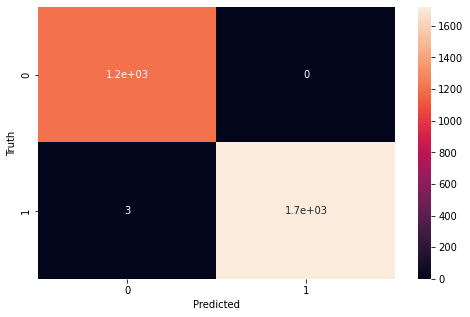

In [ ]:
DF = pd.concat([df3_class0[285207:289224], df3_class1], axis=0)
xx = DF.drop('Defect', axis='columns')
yy = DF.Defect
x__train, x__test, y__train, y__test = train_test_split(xx, yy, test_size=0.3, random_state=15,stratify=yy)
model1 = RandomForestClassifier(n_estimators=100)
prediction = model1.fit(x__train, y__train)
y_preds = model1.predict(x__test)
y_preds = np.round(y_preds)
print("\nClassification Report: \n", classification_report(y__test, y_preds))
cm = confusion_matrix(y__test, y_preds)
plt.figure(figsize = (8,5))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
print(cm)

**Testing the Ensembled Trained Model with the entire test sets to analyse the model performance**


Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.01      0.01    245866
           1       0.01      1.00      0.01      1721

    accuracy                           0.01    247587
   macro avg       0.50      0.50      0.01    247587
weighted avg       0.99      0.01      0.01    247587

[[  1647 244219]
 [     1   1720]]


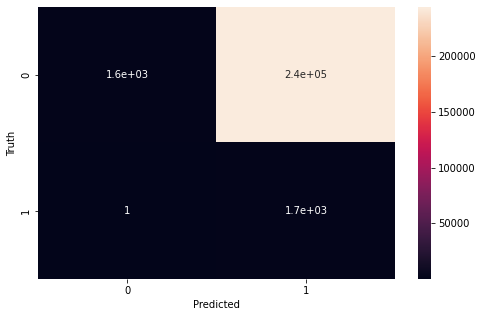

In [ ]:
Y_preds = model1.predict(X_TEST)
Y_preds = np.round(Y_preds)
print("\nClassification Report: \n", classification_report(Y_TEST, Y_preds))
cm = confusion_matrix(Y_TEST, Y_preds)
plt.figure(figsize = (8,5))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
print(cm)

***METHOD - II (SYNTHETIC MINORITY OVERSAMPLING TECHNIQUE)***

**Using SMOTE Technique to balance the imbalanced data**


Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    163911
           1       0.99      0.99      0.99    163910

    accuracy                           0.99    327821
   macro avg       0.99      0.99      0.99    327821
weighted avg       0.99      0.99      0.99    327821

[[162931    980]
 [  2016 161894]]


Text(51.0, 0.5, 'Truth')

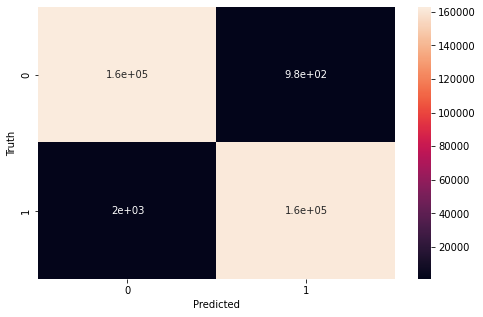

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, Y)
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=15, stratify=y_sm)
model = RandomForestClassifier(n_estimators=200)
pred = model.fit(X_train, y_train)
y_preds = model.predict(X_test)
y_preds = np.round(y_preds)
print("\nClassification Report: \n", classification_report(y_test, y_preds))
cm1 = confusion_matrix(y_test, y_preds)
print(cm1)
plt.figure(figsize = (8,5))
sn.heatmap(cm1, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
X_sm.shape

(1639104, 5)

In [ ]:
y_sm.shape

(1639104,)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=1)

In [ ]:
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)


Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98    163911
           1       0.97      0.99      0.98    163910

    accuracy                           0.98    327821
   macro avg       0.98      0.98      0.98    327821
weighted avg       0.98      0.98      0.98    327821

[[158560   5351]
 [  1914 161996]]


Text(51.0, 0.5, 'Truth')

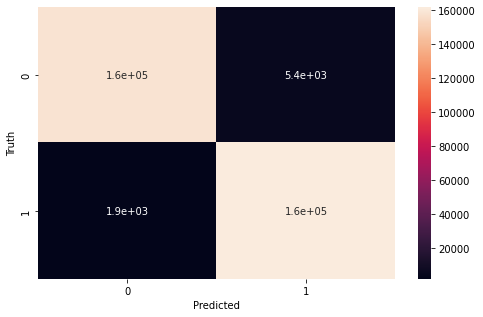

In [ ]:
Y_preds = neigh.predict(X_test)
Y_preds = np.round(Y_preds)
print("\nClassification Report: \n", classification_report(y_test, Y_preds))
cm2 = confusion_matrix(y_test, Y_preds)
print(cm2)
plt.figure(figsize = (8,5))
sn.heatmap(cm2, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')


Classification Report: 
               precision    recall  f1-score   support

           0       0.63      0.70      0.66    163911
           1       0.66      0.59      0.62    163910

    accuracy                           0.64    327821
   macro avg       0.65      0.64      0.64    327821
weighted avg       0.65      0.64      0.64    327821

[[114747  49164]
 [ 67637  96273]]


Text(51.0, 0.5, 'Truth')

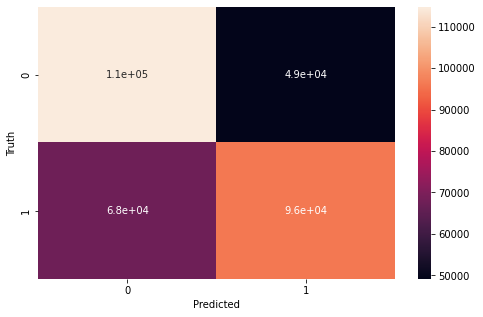

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_Preds = gnb.fit(X_train, y_train).predict(X_test)
Y_predS = np.round(y_Preds)
print("\nClassification Report: \n", classification_report(y_test, Y_predS))
cm3 = confusion_matrix(y_test, Y_predS)
print(cm3)
plt.figure(figsize = (8,5))
sn.heatmap(cm3, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')